In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy.sparse as sp
import scipy.linalg
import scipy.sparse.linalg as spla
import time
%matplotlib inline

In [2]:
import importlib.util
import checker
import test.test_generator as generator

importlib.reload(checker)
importlib.reload(generator)

A is (3, 2), k = 2
{'payoutLowRank': 44205, 'payoutNaive': 87267, 'payoutRepeatedColumns': 59089, 'payoutSparse': 88218}
A is (3, 2), k = 2
{'payoutLowRank': 44205, 'payoutNaive': 87267, 'payoutRepeatedColumns': 59089, 'payoutSparse': 88218}


<module 'test.test_generator' from '/Users/maksimshuklin/hse/coursework/test/test_generator.py'>

In [3]:
n = 50
matrix = generator.generate_sparse(n, n)
assets_cost = [i for i in range(n)]

In [4]:
checker.get_timings(matrix, assets_cost)

A is (50, 50), k = 50


{'payoutLowRank': 6665078,
 'payoutNaive': 4292803,
 'payoutRepeatedColumns': 4659049,
 'payoutSparse': 2237486}

In [5]:
X = [i * 10 for i in range(1, 9)]
naive = []
sparse = []
repeated_cols = []
low_rank = []
for x in X:
    matrix = generator.generate_sparse(x, x)
    assets_cost = [i for i in range(x)]
    j = checker.get_timings(matrix, assets_cost)
    naive.append(j['payoutNaive'])
    sparse.append(j['payoutSparse'])
    repeated_cols.append(j['payoutRepeatedColumns'])
    low_rank.append(j['payoutLowRank'])

A is (10, 10), k = 9
A is (20, 20), k = 19
A is (30, 30), k = 30
A is (40, 40), k = 40
A is (50, 50), k = 50
A is (60, 60), k = 60
A is (70, 70), k = 70
A is (80, 80), k = 80


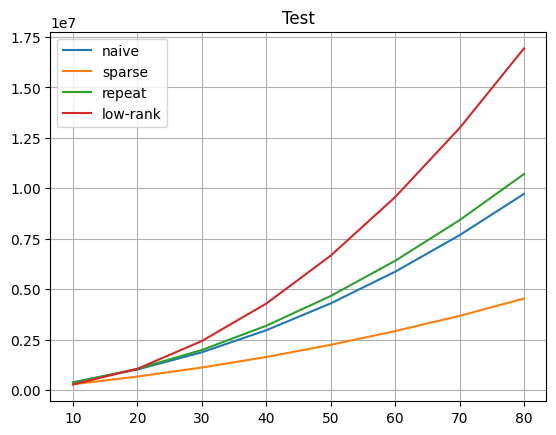

In [6]:
plt.plot(X, np.c_[naive, sparse, repeated_cols, low_rank])
plt.legend(["naive", "sparse", "repeat", "low-rank"])
plt.title("Test")
plt.grid(True)
plt.show()

# Тестируем реализации

На данный момент мною реализовано 4 алгоритма для payout-функции:

1. Наивная реализация: `payoutNaive`. Хранит матрицу в несжатом виде, алгоритм выплаты – наивный
2. Алгоритм для разреженной матрицы: `payoutSparse`. Хранит матрицу в сжатом виде (формат *COO*)
3. Алгоритм для дублирующихся столбцов: `payoutRepeatedColumns`. Хранит матрицу в сжатом виде
4. Алгоритм для малоранговой матрицы: `payoutLowRank`. Случай повторяющихся столбцов *(3)* является частным случаем малоранговой матрицы, но при этом в нем можно сделать более эффективную оптимизацию количества газа.

Посмотрим, какие преимущества дает каждый из алгоритмов. Для этого протестируем эти алгоритмы для различных наборах входных данных:
* Плотные матрицы
* Разреженные матрицы (степень разреженности задается параметров `capacity`)
* Матрицы с повторяющимися столбцами
* Малоранговые матрицы
* Квадратные матрицы
* Прямоугольные высокие матрицы и прямоугольные широкие матрицы

### Плотные матрицы

**Плотная матрица** – это матрица, в которой мало нулевых элементов. Не будем предполагать, что у этой матрицы есть какая-то особенная структура (малый ранг, повторяющиемся столбцы/элементы и т.д.)

Посмотрим, сколько газа потребляет каждый из алгоритмов в данном случае:

In [7]:
def get_gas_info_dense(X):
    naive = []
    sparse = []
    repeated_cols = []
    low_rank = []
    for x in X:
        matrix = generator.generate_random(x, x)
        assets_cost = [i for i in range(x)]
        j = checker.get_timings(matrix, assets_cost)
        naive.append(j.get('payoutNaive'))
        sparse.append(j.get('payoutSparse'))
        repeated_cols.append(j.get('payoutRepeatedColumns'))
        low_rank.append(j.get('payoutLowRank'))
    return naive, sparse, repeated_cols, low_rank

In [8]:
X_dense = [10 * i for i in range(1, 11)]
naive, sparse, repeated_cols, low_rank = get_gas_info_dense(X_dense)

A is (10, 10), k = 10
A is (20, 20), k = 20
A is (30, 30), k = 30
A is (40, 40), k = 40
A is (50, 50), k = 50
A is (60, 60), k = 60
A is (70, 70), k = 70
A is (80, 80), k = 80
A is (90, 90), k = 90
A is (100, 100), k = 100


In [9]:
print(naive)
print(sparse)
print(repeated_cols)

[404527, 1021351, 1878939, 2977255, 4316539, 5896683, 7717447, 9778939, 12081411, 14624851]
[469182, 1314890, 2560914, 4203166, 6255846, 8712918, 11549986, 14787370, 18459554, 22568666]
[391933, 1056055, 1992565, 3201391, 4682785, 6436627, 8462713, 10761115, 13332097, 16175635]


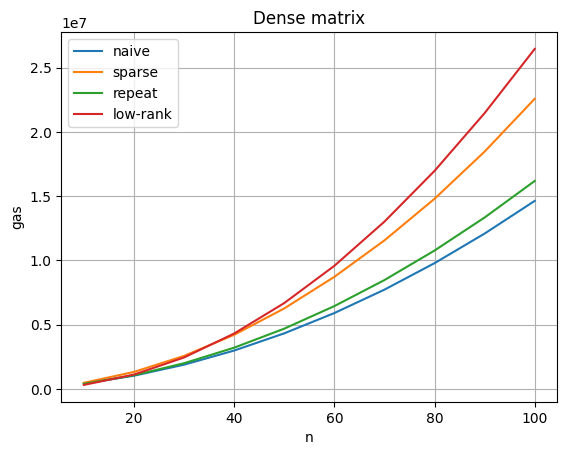

In [17]:
plt.plot(X_dense, np.c_[naive, sparse, repeated_cols, low_rank])
plt.legend(["naive", "sparse", "repeat", "low-rank"])
plt.xlabel("n")
plt.ylabel("gas")
plt.title("Dense matrix")
plt.grid(True)
plt.savefig("/Users/maksimshuklin/Desktop/pics/dense.jpg", dpi=300)
plt.show()

**Вывод:**

Видно, что с плотными матрицами быстрее работает алгоритм `payoutNaive`, который рассчитывает размер диведендов и хранит матрицу в явном виде без каких-либо оптимизаций.

При этом, как можно видеть, алгоритм `payoutSparse`, предназначенных для разреженных матриц, работает заметно хуже других алгоритмов. Это можно легко объясняется следующим фактом: для разреженной матрицы с $k$ элементами требуется хранить 3 массива размера $k$, что в случае плотных занимает в $3$ раза больше пямяти, чем наивный подход.

### Разреженные матрицы

**Разреженная матрица** – это матрица, в которой много нулей (обычно больше, чем ненулевых элементов). Не будем предполагать в этом пункте, что у матрицы есть какая-либо дополнительная структура, кроме разреженности.

Посмотрим, каким образом будет вести себя количество потребляемого газа в зависимости от используемого алгоритма и степени разреженности матрицы (`capacity`):

In [18]:
def get_gas_info_sparse(X, capacity = 20):
    naive = []
    sparse = []
    repeated_cols = []
    low_rank = []
    for x in X:
        matrix = generator.generate_sparse(x, x)
        assets_cost = [i for i in range(x)]
        j = checker.get_timings(matrix, assets_cost)
        naive.append(j['payoutNaive'])
        sparse.append(j['payoutSparse'])
        repeated_cols.append(j['payoutRepeatedColumns'])
        low_rank.append(j.get('payoutLowRank'))
    return naive, sparse, repeated_cols, low_rank

In [19]:
X_sparse = [10 * i for i in range(1, 11)]
naive, sparse, repeated_cols, low_rank = get_gas_info_sparse(X_sparse, 20)

A is (10, 10), k = 9
A is (20, 20), k = 19
A is (30, 30), k = 30
A is (40, 40), k = 40
A is (50, 50), k = 50
A is (60, 60), k = 60
A is (70, 70), k = 70
A is (80, 80), k = 80
A is (90, 90), k = 90
A is (100, 100), k = 100


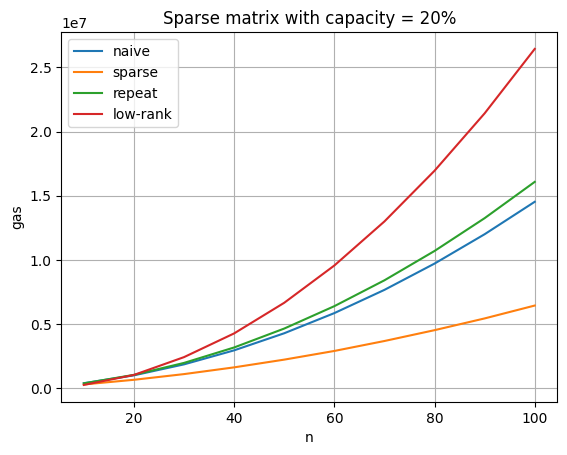

In [20]:
plt.plot(X_sparse, np.c_[naive, sparse, repeated_cols, low_rank])
plt.legend(["naive", "sparse", "repeat", "low-rank"])
plt.xlabel("n")
plt.ylabel("gas")
plt.title("Sparse matrix with capacity = 20%")
plt.grid(True)
plt.savefig("/Users/maksimshuklin/Desktop/pics/sparse_20.jpg", dpi=300)
plt.show()

**Вывод:**

Видно, что алгоритм для разреженных матриц заметно выигрывает (разница более чем в два раза).

При этом, что интересно подметить, алгоритм `payoutRepeatedColumns` для матриц с одинаковыми столбцами несколько медленне, чем наивный `payoutNaive`. Объяснить этом можно тем, что из-за особенности хранения данных в `payoutRepeatedColumns`, на матрицах без нужной структуры есть небольшой оверхед, по сравнению с `payoutNaive`

### Повторяющиеся столбцы

Под матрицей с повторяющимися столбцами будем подразумевать следующее:

* Пусть есть некоторый набор столбцов $A_1, \ldots, A_k$, где $k << n$
* Тогда искомая матрица $A \in \mathbb{R}^{n \times n}$ имеет вид:
$$
A = \left( A_{i_1} | A_{i_2} | \ldots | A_{i_n} \right) \text{, где } i_j = 1 \ldots k
$$

In [21]:
def get_gas_info_repeated(X, capacity = 20):
    naive = []
    sparse = []
    repeated_cols = []
    low_rank = []
    for x in X:
        r = (capacity * x) // 100
        matrix = generator.generate_repeated_columns(x, x, r)
        assets_cost = [i for i in range(x)]
        j = checker.get_timings(matrix, assets_cost)
        naive.append(j.get('payoutNaive'))
        sparse.append(j.get('payoutSparse'))
        repeated_cols.append(j.get('payoutRepeatedColumns'))
        low_rank.append(j.get('payoutLowRank'))
    return naive, sparse, repeated_cols, low_rank

In [22]:
X_repeated = [10 * i for i in range(1, 11)]
naive_rep, sparse_rep, repeated_cols_rep, low_rank_rep = get_gas_info_repeated(X_repeated, 20)

A is (10, 10), k = 2
A is (20, 20), k = 4
A is (30, 30), k = 6
A is (40, 40), k = 8
A is (50, 50), k = 10
A is (60, 60), k = 12
A is (70, 70), k = 13
A is (80, 80), k = 16
A is (90, 90), k = 18
A is (100, 100), k = 20


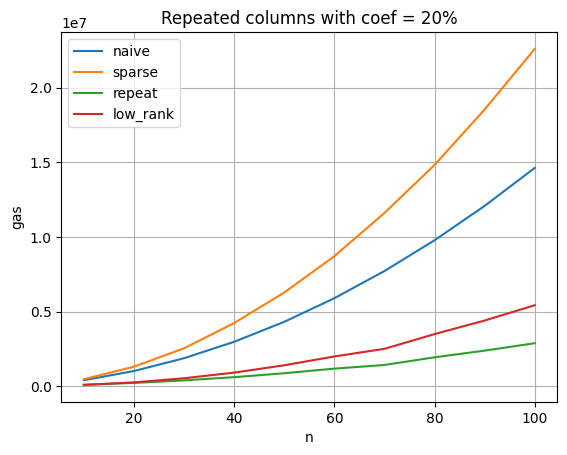

In [23]:
plt.plot(X_repeated, np.c_[naive_rep, sparse_rep, repeated_cols_rep, low_rank_rep])
plt.legend(["naive", "sparse", "repeat", "low_rank"])
plt.xlabel("n")
plt.ylabel("gas")
plt.title("Repeated columns with coef = 20%")
plt.grid(True)
plt.savefig("/Users/maksimshuklin/Desktop/pics/repeated_20.jpg", dpi=300)
plt.show()

In [24]:
n = 100
m = 50
k = 4
L = np.random.randint(0, 100, (n, k))
R = np.random.randint(0, 100, (k, m))
A = L @ R

U, S, VT = np.linalg.svd(A, full_matrices=False)
A2 = (U[:, :k] * S[:k]) @ VT[:k, :]

### Матрицы малого ранга

В данном разделе будем предполагать, что исходная матрица $A \in \mathbb{R}^{n \times n}$ имеет ранг, заметно меньший, чем $n$, т.е. $rank{A} \ll n$. Например, $k \approx \frac{1}{5}n$. 

Параметр ``capacity`` задает отношение $\frac{rank A}{n}$. Положим в данной секции, что ``capacity = 20%``

In [25]:
def get_gas_info_low_rank(X, capacity = 20):
    naive = []
    sparse = []
    repeated_cols = []
    low_rank = []
    for x in X:
        r = (capacity * x) // 100
        print(f"N={x}, r={r}")
        matrix = generator.generate_low_rank(x, x, r)
        assert np.array(matrix).shape == (x, x)
        assets_cost = [i for i in range(x)]
        j = checker.get_timings(matrix, assets_cost)
        naive.append(j.get('payoutNaive'))
        sparse.append(j.get('payoutSparse'))
        repeated_cols.append(j.get('payoutRepeatedColumns'))
        low_rank.append(j.get('payoutLowRank'))
    return naive, sparse, repeated_cols, low_rank

In [26]:
X_repeated = [10 * i for i in range(1, 11)]
naive_lr, sparse_lr, repeated_cols_lr, low_rank_lr = get_gas_info_low_rank(X_repeated, 20)

N=10, r=2
A is (10, 10), k = 2
N=20, r=4
A is (20, 20), k = 4
N=30, r=6
A is (30, 30), k = 6
N=40, r=8
A is (40, 40), k = 8
N=50, r=10
A is (50, 50), k = 10
N=60, r=12
A is (60, 60), k = 12
N=70, r=14
A is (70, 70), k = 14
N=80, r=16
A is (80, 80), k = 16
N=90, r=18
A is (90, 90), k = 18
N=100, r=20
A is (100, 100), k = 20


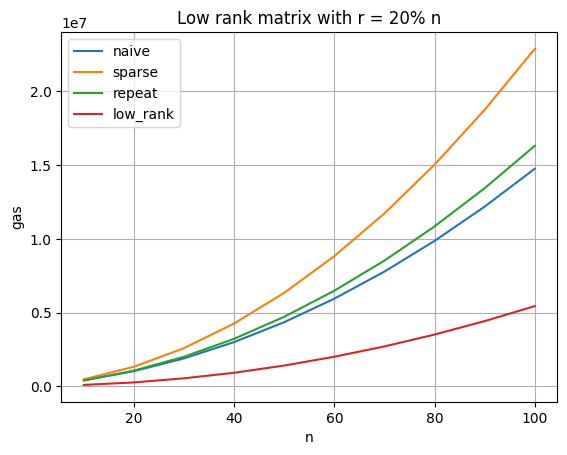

In [27]:
plt.plot(X_repeated, np.c_[naive_lr, sparse_lr, repeated_cols_lr, low_rank_lr])
plt.legend(["naive", "sparse", "repeat", "low_rank"])
plt.xlabel("n")
plt.ylabel("gas")
plt.title("Low rank matrix with r = 20% n")
plt.grid(True)
plt.savefig("/Users/maksimshuklin/Desktop/pics/low_rank_20.jpg", dpi=300)
plt.show()

In [175]:
n = 100
r = 20 * n // 100
matrix = generator.generate_low_rank(n, n, r)
A = np.array(matrix)

In [176]:
U, S, VT = np.linalg.svd(A, full_matrices=False)
S

array([5.12730208e+06, 1.27111254e+05, 1.20047554e+05, 1.08939340e+05,
       1.02151863e+05, 9.66828588e+04, 9.41504295e+04, 8.85262281e+04,
       8.71767323e+04, 8.33069932e+04, 7.45863157e+04, 7.02403968e+04,
       6.79951964e+04, 6.41047710e+04, 6.11553577e+04, 5.86768493e+04,
       5.06884475e+04, 4.88006152e+04, 4.21735345e+04, 3.78892832e+04,
       8.32120949e-10, 5.64634098e-10, 5.64634098e-10, 5.64634098e-10,
       5.64634098e-10, 5.64634098e-10, 5.64634098e-10, 5.64634098e-10,
       5.64634098e-10, 5.64634098e-10, 5.64634098e-10, 5.64634098e-10,
       5.64634098e-10, 5.64634098e-10, 5.64634098e-10, 5.64634098e-10,
       5.64634098e-10, 5.64634098e-10, 5.64634098e-10, 5.64634098e-10,
       5.64634098e-10, 5.64634098e-10, 5.64634098e-10, 5.64634098e-10,
       5.64634098e-10, 5.64634098e-10, 5.64634098e-10, 5.64634098e-10,
       5.64634098e-10, 5.64634098e-10, 5.64634098e-10, 5.64634098e-10,
       5.64634098e-10, 5.64634098e-10, 5.64634098e-10, 5.64634098e-10,
      